In [2]:
# Python imports
import importlib
import os
import random
import warnings

# Third-party imports
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot
from monai.losses.dice import DiceLoss
from monai.losses.focal_loss import FocalLoss
from monai.metrics.hausdorff_distance import HausdorffDistanceMetric
from monai.metrics.meandice import DiceMetric
from monai.metrics.meaniou import MeanIoU
from PIL import Image
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode
from torchvision.transforms import functional as func
from tqdm import tqdm

# Local imports
from src import modules, mtl_oca, utils

importlib.reload(mtl_oca)
importlib.reload(modules)
importlib.reload(utils)

from src.modules import ResUNet
from src.mtl_oca import MultiTaskOCAModel
from src.utils import BreastDataset, BreastTestDataset, JointTransform, create_csv, process_segmentation, train

# Silence annoying warnings 🙄
warnings.filterwarnings("ignore", category=FutureWarning, message=".*always_return_as_numpy.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*prediction of class 0 is all 0.*")

In [3]:
SEED: int = 42
BATCH_SIZE: int = 32
NUM_WORKERS: int = 0
DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FILTERS: tuple[int, ...] = (32, 64, 128, 256, 512)
IMAGE_SIZE: list[int] = [128, 128]
MODEL_NAME: str = "MultiTaskOCAModel.pt"


# Set seed to ensure consistency across runs
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
TRAIN_DIR: str = os.path.join(os.getcwd(), "images", "Train")
VAL_DIR: str = os.path.join(os.getcwd(), "images", "Val")


def verify_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    # Keep only rows where both image_path and mask_path exist
    valid_df = df[df.apply(lambda row: os.path.exists(row["image_path"]) and os.path.exists(row["mask_path"]),
                           axis=1)].reset_index(drop=True)
    removed = len(df) - len(valid_df)
    print(f"Removed {removed} rows with missing files.")

    return valid_df


train_data_df = create_csv(TRAIN_DIR)
val_data_df = create_csv(VAL_DIR)

class_mapping = {"benign": 0, "malignant": 1, "normal": 2}

train_data_df["label"] = train_data_df["label"].map(class_mapping)
val_data_df["label"] = val_data_df["label"].map(class_mapping)

train_data_df["tumor_present"] = (train_data_df["label"].isin([0, 1]).map({True: 1, False: 0}))

train_data_df = verify_and_clean(train_data_df)

print(f"Number of training samples: {len(train_data_df)}")
print(f"Number of validation samples: {len(val_data_df)}")

train_data_df

Removed 4 rows with missing files.
Number of training samples: 3116
Number of validation samples: 547


,image_path,mask_path,label,tumor_present
0,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,0,1
1,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,0,1
2,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,0,1
3,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,0,1
4,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,0,1
...,...,...,...,...
3111,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,2,0
3112,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,2,0
3113,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,2,0
3114,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,c:\Users\MoyinOluwa\PycharmProjects\PRECISEAbr...,2,0


Image shape: torch.Size([32, 3, 128, 128])
Mask shape: torch.Size([32, 1, 128, 128])
Presence Label: torch.Size([32])
Type Label: torch.Size([32])


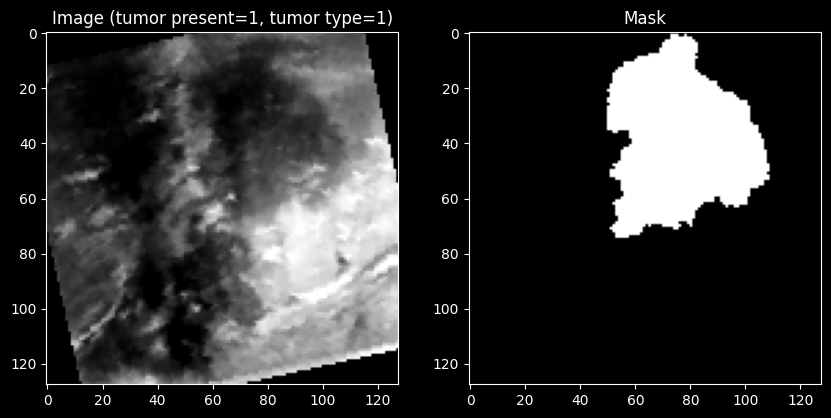

In [5]:
train_breast_data = BreastDataset(train_data_df, IMAGE_SIZE, JointTransform())
train_data_loader = DataLoader(train_breast_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                               pin_memory=True, worker_init_fn=seed_worker, generator=g)

image, (mask, presence_label, type_label) = next(iter(train_data_loader))

print("Image shape:", image.shape)  # should be (BATCH_SIZE, 3, IMAGE_SIZE)
print("Mask shape:", mask.shape)  # should be (BATCH_SIZE, 1, IMAGE_SIZE)
print("Presence Label:", presence_label.shape)  # should be (BATCH_SIZE)
print("Type Label:", type_label.shape)  # should be (BATCH_SIZE)

img_np = image[0][0].numpy()
mask_np = mask[0].squeeze(0).numpy()

pyplot.style.use("dark_background")
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(img_np, cmap="gray")
pyplot.grid(False)
pyplot.title(f"Image (tumor present={presence_label[0]}, tumor type={type_label[0]})")

pyplot.subplot(1, 2, 2)
pyplot.imshow(mask_np, cmap="gray")
pyplot.grid(False)
pyplot.title("Mask")

pyplot.show()

In [6]:
def stratified_kfold_train(df: pd.DataFrame, n_splits: int = 5, shuffle: bool = True) -> tuple[list, ...]:
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    train_dice_scores, train_hd95_scores, train_iou_scores, presence_scores, type_scores = [], [], [], [], []

    fold = 1
    for train_index, val_index in k_fold.split(df[["image_path", "mask_path"]], df["label"]):
        print(f"--- Fold {fold} ---")
        train_df = df.loc[train_index].reset_index(drop=True)
        val_df = df.loc[val_index].reset_index(drop=True)

        train_dataset = BreastDataset(train_df, IMAGE_SIZE, transforms=JointTransform())
        val_dataset = BreastDataset(val_df, IMAGE_SIZE, transforms=None)

        train_data = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                                pin_memory=True, worker_init_fn=seed_worker, generator=g)
        val_data = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                              pin_memory=True, worker_init_fn=seed_worker, generator=g)

        estimator = MultiTaskOCAModel(backbone=ResUNet(channel=3))
        optimizer = AdamW(estimator.parameters(), lr=1e-3)
        seg_loss_fn = DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        presence_loss_fn = FocalLoss(gamma=2.0, alpha=0.07)
        type_loss_fn = FocalLoss(gamma=2.0, alpha=0.70)

        output = train(model=estimator, optimizer=optimizer, seg_loss_fn=seg_loss_fn, presence_loss_fn=presence_loss_fn,
                       type_loss_fn=type_loss_fn, train_loader=train_data, val_loader=val_data, device=DEVICE,
                       epochs=100, patience=5, save_model=True, save_path=MODEL_NAME, lr_decay_factor=0.1)
        print()

        train_dice_scores.append(np.max(output["Seg_Dice_Scores"]))
        train_hd95_scores.append(np.min(output["Seg_HD95_Scores"]))
        train_iou_scores.append(np.max(output["Seg_IoU_Scores"]))
        presence_scores.append(np.max(output["Presence_AUC_Scores"]))
        type_scores.append(np.max(output["Type_AUC_Scores"]))

        fold += 1

        break  # Remove if you want to train for more than one fold.

    return train_dice_scores, train_hd95_scores, train_iou_scores, presence_scores, type_scores

In [ ]:
dice, hd95, iou, presence_auc, type_auc = stratified_kfold_train(train_data_df, n_splits=5)

print(f"Dice Score: {np.mean(dice):.4f}")
print(f"HD95 Score: {np.mean(hd95):.4f}")
print(f"IoU Score: {np.mean(iou):.4f}")
print(f"Presence AUC Score: {np.mean(presence_auc):.4f}")
print(f"Type AUC Score: {np.mean(type_auc):.4f}")

In [7]:
MODEL_PATH: str = os.path.join("models", MODEL_NAME)
model = MultiTaskOCAModel(backbone=ResUNet(channel=3))

state = torch.load(MODEL_PATH, map_location=DEVICE)
if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]

model.load_state_dict(state)
print("Model loaded.")
model.to(DEVICE)
model.eval()

NORMAL: int = 0

dice_metric = DiceMetric(include_background=False, reduction="mean")
hd95_metric = HausdorffDistanceMetric(include_background=False, percentile=95, reduction="mean")
iou_metric = MeanIoU(include_background=False, reduction="mean")

presence_labels, presence_probs = [], []
type_labels, type_probs = [], []
dice_scores, hd95_scores, iou_scores = [], [], []

kfold = StratifiedKFold(n_splits=5, shuffle=True)
for _, val_idx in kfold.split(train_data_df[["image_path", "mask_path"]], train_data_df["label"]):
    validation_df = train_data_df.loc[val_idx].reset_index(drop=True)
    validation_dataset = BreastDataset(validation_df, IMAGE_SIZE, transforms=None)
    validation_data = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                                 pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Validation
    with torch.no_grad():
        for image, (mask, presence_label, type_label) in tqdm(validation_data, desc="Testing Model Performance"):
            image, mask = image.to(DEVICE), mask.to(DEVICE)
            presence_label, type_label = presence_label.to(DEVICE), type_label.to(DEVICE)
            seg_logits, _, presence_logits, type_logits = model(image)

            target_indices = mask.squeeze(1).long()

            # Classification
            presence_proba = torch.sigmoid(presence_logits)
            type_proba = torch.sigmoid(type_logits)
            presence_preds = (presence_proba > 0.5).long()

            # Segmentation
            d, h, iou = process_segmentation(
                seg_logits, presence_preds, target_indices, dice_metric, hd95_metric, iou_metric
            )
            dice_scores.extend(d)
            hd95_scores.extend(h)
            iou_scores.extend(iou)

            presence_probs.extend(presence_proba.cpu().numpy())
            presence_labels.extend(presence_label.cpu().numpy())

            tumor_mask = presence_label == 1
            type_probs.extend(type_proba[tumor_mask].cpu().numpy())
            type_labels.extend(type_label[tumor_mask].cpu().numpy())

    break  # Remove if you want to test on more than one fold
print("Validation done.")

thresholds = np.linspace(0, 1, 101)
presence_labels, presence_probs = np.array(presence_labels), np.array(presence_probs).reshape(-1)
f1_scores: list = [f1_score(presence_labels, presence_probs >= threshold, average='weighted', zero_division=0) for threshold in
             thresholds]

best_idx = np.argmax(f1_scores)
best_presence_threshold = thresholds[best_idx]
best_presence_f1 = f1_scores[best_idx]

type_labels, type_probs = np.array(type_labels), np.array(type_probs).reshape(-1)
f1_scores = [f1_score(type_labels, type_probs >= threshold, average='weighted', zero_division=0) for threshold in
             thresholds]

best_idx = np.argmax(f1_scores)
best_type_threshold = thresholds[best_idx]
best_type_f1 = f1_scores[best_idx]

Model loaded.


Testing Model Performance: 100%|██████████| 20/20 [07:35<00:00, 22.79s/it]


Validation done.


Best presence threshold: 0.3200
Best presence F1: 0.9729

Best type threshold: 0.5500
Best type F1: 0.8550

Classification Results:
Presence Precision: 0.9730
Presence Recall: 0.9728
Presence AUC: 0.9053
Presence F1 Score: 0.9729

Type Precision: 0.8555
Type Recall: 0.8547
Type AUC: 0.8384
Type F1 Score: 0.8550

Segmentation Results:
Dice Score: 0.9159
HD95 Score: 0.8085
IoU Score: 0.8938


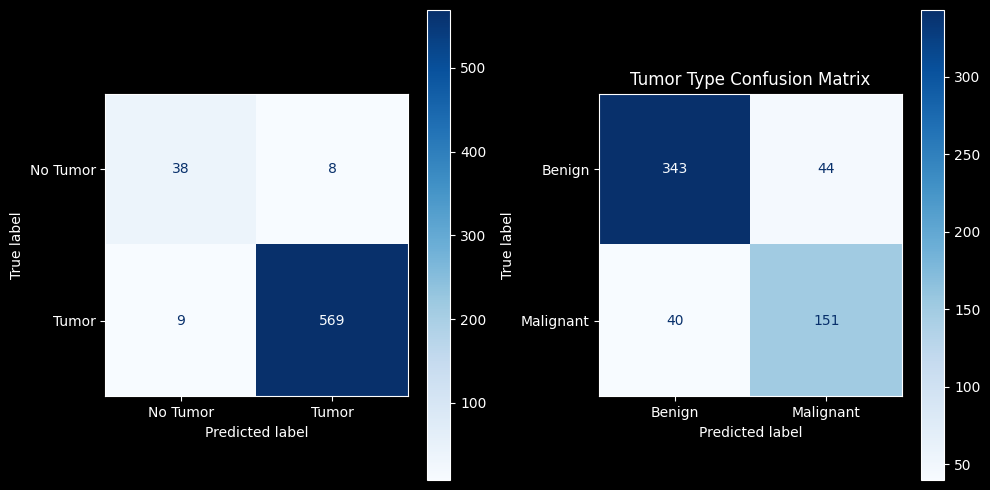

In [8]:
print(f"Best presence threshold: {best_presence_threshold:.4f}")
print(f"Best presence F1: {best_presence_f1:.4f}\n")

print(f"Best type threshold: {best_type_threshold:.4f}")
print(f"Best type F1: {best_type_f1:.4f}\n")

print("Classification Results:")
print(f"Presence Precision: {precision_score(presence_labels, presence_probs >= best_presence_threshold, average='weighted', zero_division=0):.4f}")
print(f"Presence Recall: {recall_score(presence_labels, presence_probs >= best_presence_threshold, average='weighted', zero_division=0):.4f}")
print(f"Presence AUC: {roc_auc_score(presence_labels, presence_probs >= best_presence_threshold, average='weighted'):.4f}")
print(f"Presence F1 Score: {f1_score(presence_labels, presence_probs >= best_presence_threshold, average='weighted', zero_division=0):.4f}\n")

print(f"Type Precision: {precision_score(type_labels, type_probs >= best_type_threshold, average='weighted', zero_division=0):.4f}")
print(f"Type Recall: {recall_score(type_labels, type_probs >= best_type_threshold, average='weighted', zero_division=0):.4f}")
print(f"Type AUC: {roc_auc_score(type_labels, type_probs >= best_type_threshold, average='weighted'):.4f}")
print(f"Type F1 Score: {f1_score(type_labels, type_probs >= best_type_threshold, average='weighted', zero_division=0):.4f}\n")

print("Segmentation Results:")
print(f"Dice Score: {np.mean(dice_scores):.4f}")
print(f"HD95 Score: {np.mean(hd95_scores):.4f}")
print(f"IoU Score: {np.mean(iou_scores):.4f}")

presence_matrix = confusion_matrix(presence_labels, presence_probs >= best_presence_threshold)
type_matrix = confusion_matrix(type_labels, type_probs >= best_type_threshold)

presence_disp = ConfusionMatrixDisplay(confusion_matrix=presence_matrix, display_labels=["No Tumor", "Tumor"])
type_disp = ConfusionMatrixDisplay(confusion_matrix=type_matrix, display_labels=["Benign", "Malignant"])

_, axes = pyplot.subplots(1, 2, figsize=(10, 5))
presence_disp.plot(cmap="Blues", values_format="d", ax=axes[0])
pyplot.title("Tumor Presence Confusion Matrix")
type_disp.plot(cmap="Blues", values_format="d", ax=axes[1])
pyplot.title("Tumor Type Confusion Matrix")
pyplot.tight_layout()

pyplot.show()

Validation: 100%|██████████| 18/18 [05:50<00:00, 19.48s/it]


Testing done.
Precision: 0.7916
Recall: 0.7934
AUC: 0.7871
F1 Score: 0.7921


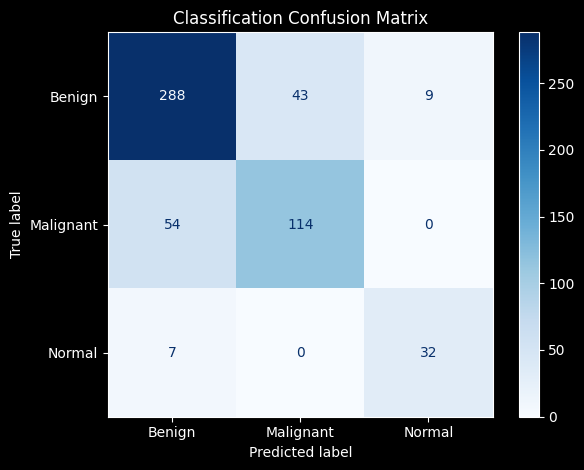

In [15]:
validation_dataset = BreastTestDataset(val_data_df, IMAGE_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

predictions, true_labels, image_ids = [], [], []
segmentation_path = os.path.join("submission", "segmentation")
os.makedirs(segmentation_path, exist_ok=True)

with torch.no_grad():
    for image, image_path, mask_path, original_image_size, label in tqdm(validation_dataloader, desc="Validation"):
        heights, widths = original_image_size[0], original_image_size[1]
        image = image.to(DEVICE)

        seg_logits, _, presence_logits, type_logits = model(image)

        # Classification
        true_labels.extend(label)
        presence_probs = torch.sigmoid(presence_logits)
        type_probs = torch.sigmoid(type_logits)

        presence_preds = (presence_probs >= best_presence_threshold).long().squeeze(1)
        type_preds = (type_probs >= best_type_threshold).long().squeeze(1)
        normal_class = torch.tensor(2, dtype=torch.long, device=DEVICE)

        cls_preds = torch.where((presence_preds == NORMAL).bool(), normal_class.expand_as(type_preds), type_preds)

        for i, value in enumerate(presence_preds):
            # Get image id (filename without extension)
            img_name = os.path.basename(image_path[i])
            image_id = os.path.splitext(img_name)[0]

            # Store prediction
            predictions.append(cls_preds[i].item())
            image_ids.append(image_id)

            # Segmentation
            # Resize to the original size
            seg_resized = func.resize(
                seg_logits[i].unsqueeze(0), [heights[i].item(), widths[i].item()],
                interpolation=InterpolationMode.BILINEAR
            )
            seg_pred = seg_resized.squeeze(0)
            seg_pred = torch.argmax(seg_pred, dim=0).long().cpu()

            # If NORMAL is predicted, force mask to the background
            if value.item() == NORMAL:
                seg_pred = torch.zeros_like(seg_pred)

            # seg_pred is a 2D tensor with values {0, 1}
            seg_np = seg_pred.cpu().numpy().astype("uint8") * 255  # 0 -> 0, 1 -> 255
            seg_img = Image.fromarray(seg_np)
            seg_img.save(os.path.join(segmentation_path, f"{image_id}_mask.png"))
print("Testing done.")

predictions = np.array(predictions)
true_labels = np.array(true_labels)

precision = precision_score(true_labels, predictions, average="weighted")
recall = recall_score(true_labels, predictions, average="weighted")
auc = roc_auc_score(true_labels, pd.get_dummies(predictions), multi_class='ovr', average='weighted')
f1 = f1_score(true_labels, predictions, average="weighted")
matrix = confusion_matrix(true_labels, predictions)
matrix = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Benign", "Malignant", "Normal"])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

matrix.plot(cmap="Blues", values_format="d")
pyplot.title("Classification Confusion Matrix")
pyplot.tight_layout()
pyplot.savefig(os.path.join("submission", "confusion_matrix.png"))
pyplot.show()

In [11]:
# Create submission dataframe
submission_df = pd.DataFrame({"image_id": image_ids, "label": predictions})
label_map = {0: "Benign", 1: "Malignant", 2: "Normal"}
submission_df["label"] = submission_df["label"].map(label_map)

# Save submission CSV
submission_df.to_csv(os.path.join("submission", "classification.csv"), index=False)

print("Submission saved in 'submission/' folder.")

Submission saved in 'submission/' folder.
